In [1]:
import logging
import yaml

import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import asyncio

# import palpy

from lsst.ts import salobj

from lsst.ts.standardscripts.auxtel.attcs import ATTCS

from lsst.ts.idl.enums import ATPtg

%matplotlib inline

In [2]:
from astropy.utils import iers
iers.conf.auto_download = False

In [3]:
u.imperial.enable()

In [ ]:
d = salobj.Domain()

In [ ]:
atmcs = salobj.Remote(d, "ATMCS")
atptg = salobj.Remote(d, "ATPtg")
atpne = salobj.Remote(d, "ATPneumatics")

In [ ]:
await asyncio.gather(atmcs.start_task, 
                     atptg.start_task, 
                     atpne.start_task)

In [ ]:
class MeasureM1Pressure():
    
    def __init__(self, atmcs, atpne):
        
        self.atmcs = atmcs
        self.atpne = atpne
        
        self.elevation = np.array([])
        self.pressure = np.array([])
        self.load_off = np.array([])
        self.max_load = np.array([])
        self.min_load = np.array([])
        
        self.min_allowed_load = 120.
        self.optimum_fraction = 1./27.
        self.tolerance = 0.1
        
    async def get_load(self, n=10):
        
        load_measures = np.zeros(n)
        for i in range(n):
            load = await self.atpne.tel_loadCell.next(flush=True, timeout=2)
            load_measures[i] = load.cellLoad
            
        return np.mean(load_measures)
    
    async def get_pressure(self, n=10):
        
        pressure_measures = np.zeros(n)
        for i in range(n):
            topic = await self.atpne.tel_m1AirPressure.next(flush=True, timeout=3)
            pressure_measures[i] = topic.pressure
            
        return np.mean(pressure_measures)*u.Pa    

    async def measure_optimum_pressure(self):
        
        encoders = await atmcs.tel_mount_AzEl_Encoders.next(flush=True, timeout=5)
        
        
        await self.atpne.cmd_m1CloseAirValve.start()
        await asyncio.sleep(5.)
        
        closed_air_load = await self.get_load()
        
        print(f"Closed valve load: {closed_air_load}")
                
        self.atpne.evt_m1State.flush()
        await self.atpne.cmd_m1OpenAirValve.start()    
        master_valve = await self.atpne.evt_m1State.next(flush=False, timeout=30)

        self.atpne.cmd_m1SetPressure.set(pressure=0.1)
        self.atpne.evt_m1SetPressure.flush()
        await self.atpne.cmd_m1SetPressure.start()
        try:
            sp = await self.atpne.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        open_air_load = await self.get_load()
        
        optimum_load = open_air_load * self.optimum_fraction

        print(f"Optimum load: {optimum_load}")
        
        min_pressure = await self.get_pressure()

        print(f"Minimum pressure: {min_pressure}")

        max_pressure = 15. * np.sin(np.radians(np.mean(encoders.elevationCalculatedAngle))) * min_pressure

        print(f"Maximum pressure: {max_pressure.to(u.Pa)}")

        print(f"Max/Min pressure: {max_pressure.to(u.Pa)/min_pressure}")

        max_load = await self.get_load()  # Max load is with minumum pressure 

        print(f"Max load: {max_load}")
        
#         if max_load > optimum_load:
#             print(f"Max load larger then optimum. Operation complete.")
#             self.elevation = np.append(self.elevation, encoders.elevationCalculatedAngle)
#             self.pressure = np.append(self.pressure, min_pressure)
#             return 

        self.atpne.cmd_m1SetPressure.set(pressure=max_pressure.to(u.Pa).value)
        self.atpne.evt_m1SetPressure.flush()
        await self.atpne.cmd_m1SetPressure.start()
        try:
            sp = await self.atpne.evt_m1SetPressure.next(flush=False, timeout=120)
        except asyncio.TimeoutError:
            pass

        measured_pressure = await self.get_pressure()

        min_load = await self.get_load()
        
        if min_load < self.min_allowed_load:
#             attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)
#             await attcs.atpneumatics.cmd_m1SetPressure.start()
            print(f"Min load {min_load} to small {self.min_allowed_load}. ")
#             return 
            
        print(f"Min load: {min_load}")

        init_pressure = (min_pressure+max_pressure.to(u.Pa))/2.
        print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

        self.atpne.cmd_m1SetPressure.set(pressure=init_pressure.to(u.Pa).value)
        self.atpne.evt_m1SetPressure.flush()
        await self.atpne.cmd_m1SetPressure.start()
        try:
            sp = await self.atpne.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        niter = 0
        max_iter = 21
        success = True

        init_pressure = (min_pressure+max_pressure.to(u.Pa))/2.
        print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

        self.atpne.cmd_m1SetPressure.set(pressure=init_pressure.to(u.Pa).value)
        self.atpne.evt_m1SetPressure.flush()
        await self.atpne.cmd_m1SetPressure.start()
        try:
            sp = await self.atpne.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        load = await self.get_load()
        
        print("****")
        print(f"load: {load}")
        print(f"Optimum load: {optimum_load}")
        delta = np.abs(load - optimum_load)/optimum_load
        print(f"{delta} > 0.1")
        print("****")

        
        while delta > self.tolerance:
            niter += 1
            print(f"Iter {niter}")
            print(f"Dif: {load-optimum_load}")
            print(f"delta: {delta}")

            if load < optimum_load:
                print(f"Current load ({load}) less then optimum load ({optimum_load}). Max pressure = init_pressure.")
                max_pressure = init_pressure
            else:
                print(f"Current load ({load}) larger then optimum load ({optimum_load}). Min pressure = init_pressure.")                
                min_pressure = init_pressure
                
            init_pressure = (min_pressure+max_pressure)/2.

            print(f"{min_pressure} < {init_pressure} < {max_pressure}")
            
            print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

            await self.atpne.cmd_m1SetPressure.set_start(pressure=0.)
            self.atpne.evt_m1SetPressure.flush()
            await self.atpne.cmd_m1SetPressure.set_start(pressure=init_pressure.to(u.Pa).value)
            try:
                sp = await self.atpne.evt_m1SetPressure.next(flush=True, timeout=30)
            except asyncio.TimeoutError:
                print("Could not get set pressure event!")
                pass
            
            measured_pressure = await self.get_pressure()
            
            print(f"Set pressure: {init_pressure.to(u.Pa)}")
            print(f"Measured pressure: {measured_pressure}")
            print(f"Diff: {init_pressure.to(u.Pa).value-measured_pressure.to(u.Pa).value}")

            load = await self.get_load()

            print("****")
            print(f"load: {load}")
            print(f"Optimum load: {optimum_load}")
            delta = np.abs(load - optimum_load)/optimum_load
            print(f"diff: {delta} | tol: {self.tolerance}")
            print("****")
            
            

            if niter > max_iter:
                print("Failed")
                success = False
                break

        if success:
            print("Success!")
            optimum_pressure = await self.get_pressure()
            print(f"Optimum pressure: {optimum_pressure} @ el {np.mean(encoders.elevationCalculatedAngle)}")        
            self.elevation = np.append(self.elevation, np.mean(encoders.elevationCalculatedAngle))
            self.pressure = np.append(self.pressure, optimum_pressure.to(u.Pa).value)    
            
        self.atpne.cmd_m1SetPressure.set(pressure=0.1)
        await self.atpne.cmd_m1SetPressure.start()




In [ ]:
mp = MeasureM1Pressure(atmcs, atpne)

In [ ]:
await atpne.cmd_openMasterAirSupply.start(timeout=30)

In [ ]:
await atpne.cmd_openInstrumentAirValve.start(timeout=30)

In [ ]:
await atpne.cmd_m1OpenAirValve.start()

In [ ]:
await atpne.cmd_m1OpenAirValve.start()

In [ ]:
await asyncio.sleep(5)
await atmcs.tel_mount_AzEl_Encoders.next(flush=True, timeout=2)
await asyncio.sleep(5)
await atmcs.tel_mount_AzEl_Encoders.next(flush=True, timeout=2)

In [ ]:
await atptg.cmd_stopTracking.start()

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=0., elDegs=87.)

In [ ]:
pressure = await mp.get_pressure()

In [ ]:
load = await mp.get_load()

In [ ]:
load = load*u.kg
print(load, load/24.)

In [ ]:
load.to(u.imperial.lb)/10.

In [ ]:
await asyncio.sleep(1.)

In [ ]:
await mp.measure_optimum_pressure()

In [ ]:
encoders = await atmcs.tel_mount_AzEl_Encoders.next(flush=True, timeout=5)

In [ ]:
np.mean(encoders.elevationCalculatedAngle)

In [ ]:
master_valve = await atpne.evt_m1State.next(flush=False, timeout=2)

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=0., elDegs=70.)

In [ ]:
# poly = np.poly1d(fit)
# x = np.linspace(22., 90., 100)
# y = poly(x)
plt.plot(mp.elevation, mp.pressure/1e3, 'o')
# plt.plot(x, y/1e3, '-')
plt.grid()
plt.xlabel("Altitude (deg)")
plt.ylabel("Pressure (kPa)")

In [ ]:
# poly = np.poly1d(fit)
# x = np.linspace(22., 90., 100)
# y = poly(x)
plt.plot(mp.elevation, mp.pressure/1e3, 'o')
# plt.plot(x, y/1e3, '-')
plt.grid()
plt.xlabel("Altitude (deg)")
plt.ylabel("Pressure (kPa)")

In [ ]:
data = np.array([mp.elevation, mp.pressure])

In [ ]:
np.save("alt_pressure.npy", data)

In [4]:
data = np.load("alt_pressure.npy")

In [5]:
data

array([[7.98480896e+01, 7.00000000e+01, 5.99999999e+01, 5.00000001e+01,
        4.00000000e+01, 2.99999999e+01, 3.50000000e+01, 4.49999975e+01,
        5.50000004e+01, 6.50000010e+01, 7.49999995e+01, 8.49999997e+01,
        7.49999994e+01, 6.99999997e+01, 7.00000000e+01],
       [1.30607392e+05, 1.32605458e+05, 1.13061608e+05, 9.92882893e+04,
        8.48631166e+04, 6.03924838e+04, 7.29877088e+04, 9.57929355e+04,
        1.07871180e+05, 1.17147376e+05, 1.36667239e+05, 1.29925027e+05,
        1.27229868e+05, 1.36715003e+05, 1.26503949e+05]])

In [6]:
mask = np.zeros(len(data[0]))==0

In [17]:
fit1 = np.polyfit(np.cos(np.radians(90. - data[0])[mask]), data[1][mask], 1)
fit2 = np.polyfit(np.cos(np.radians(90. - data[0])[mask]), data[1][mask], 2)
fit3 = np.polyfit(np.cos(np.radians(90. - data[0][mask])), data[1][mask], 3)

In [18]:
fit1

array([138277.38566765,  -5923.19461273])

In [22]:
fit1_1 = np.copy(fit1)
fit1_1[1] -= 5000.
fit1_1

array([138277.38566765, -10923.19461273])

Text(0, 0.5, 'Pressure (kPa)')

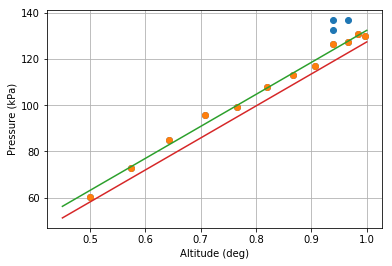

In [20]:
poly1 = np.poly1d(fit1)
poly1_1 = np.poly1d(fit1_1)
poly2 = np.poly1d(fit2)
poly3 = np.poly1d(fit3)
x = np.linspace(0.45, 1, 100)
y1 = poly1(x)
y1_1 = poly1_1(x)
y2 = poly2(x)
y3 = poly3(x)
# np.cos(np.radians(90. - elevation))
plt.plot(np.cos(np.radians(90. - data[0])), data[1]/1e3, 'o')
plt.plot(np.cos(np.radians(90. - data[0][mask])), data[1][mask]/1e3, 'o')
plt.plot(x, y1/1e3, '-')
plt.plot(x, y1_1/1e3, '-')
# plt.plot(x, y2/1e3, '-')
# plt.plot(x, y3/1e3, '-')
plt.grid()
plt.xlabel("Altitude (deg)")
plt.ylabel("Pressure (kPa)")

In [ ]:
data[0]

In [7]:
mask[1] = False
mask[10] = False
mask[-2] = False

In [ ]:
altitude=87.
poly1(np.cos(np.radians(90. - altitude)))

In [ ]:
await atptg.cmd_azElTarget.set_start(azDegs=0., elDegs=80.)

In [ ]:
await atptg.cmd_stopTracking.start()

In [ ]:
await atpne.cmd_m1SetPressure.set_start(pressure=0.)